In [1]:
from xgboost import XGBClassifier
import warnings
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from tabpfn_new.scripts.transformer_prediction_interface import TabPFNClassifier, MedPFNClassifier
from tabpfn_new.scripts.model_builder import load_model
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
from evaluate import *
#from load_models import *
import matplotlib.pyplot as plt
import math
import torch
import openml
import time
import matplotlib as mpl
#pd.set_option('display.expand_frame_repr', False)

In [2]:
path = "datasets/data_all.csv"
all_data, labels = get_microbiome(path)
all_data = remove_zero_features(all_data)
all_data, labels = unison_shuffled_copies(all_data, labels, seed=42)

In [3]:
print(np.max(all_data))

1.0


In [9]:

reducer = AnovaSelect()
reducer.fit(all_data,labels)
scores = reducer.anova.scores_
reducer2 = AnovaSelect()
p = np.random.permutation(all_data.shape[1])
p_rev = np.argsort(p)
reducer2.fit(all_data[:,p],labels)
data1 = reducer.transform(all_data)
data2 = reducer2.transform(all_data[:,p])
print(np.max(data1), np.max(data2))

0.9775588977558897 0.9775588977558897


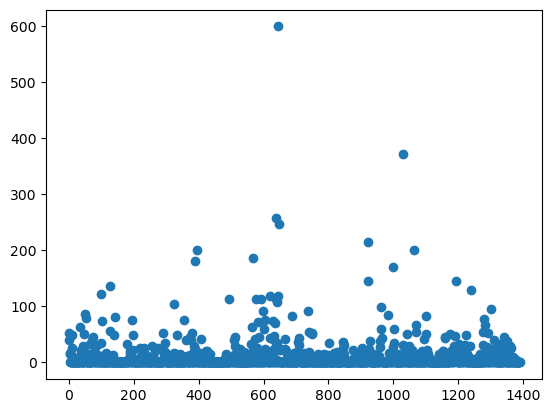

62


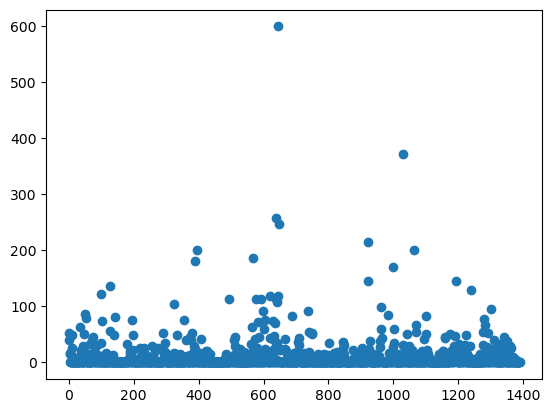

In [11]:
scores = reducer.anova.scores_
#_ = plt.hist(scores,100)
plt.scatter(np.arange(scores.shape[0]), scores)
plt.show()
scores2 = reducer2.anova.scores_
#_ = plt.hist(scores2[scores2>10],100)
plt.scatter(np.arange(scores2.shape[0]), scores2[p_rev])
print(np.sum(1*(scores>50)))

In [11]:
def small_eval(model, X_train, y_train, X_test, y_test):
    results = np.empty(2)
    with torch.no_grad():
        model.fit(X_train, y_train, overwrite_warning=True)
        probs = model.predict_proba(X_test)
        preds = np.argmax(probs, axis=1)
        y_test_1hot = torch.nn.functional.one_hot(torch.tensor(y_test).to(torch.int64)).numpy()
        results[0] = (sklearn.metrics.get_scorer("roc_auc")._score_func(y_test_1hot, probs, multi_class="ovr"))
        results[1] = (sklearn.metrics.get_scorer("f1")._score_func(y_test, preds))
    return results

### Feature importance - Leave-one-covariate-out (LOCO)

In [24]:
save = True
sampling = None
cv = 3
best_delete = 0
strat_split = True
max_samples = 1024
preprocess = "none"
multi_decoder = "permutation"
N_ens = 1
seed = 42
overwrite = True
metrics = ["roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"

model = MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder, preprocess_mode=preprocess)
#model = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic')


reducer = AnovaSelect()




size = min(labels.shape[0],np.floor(max_samples*(cv/(cv-1))))
runs = int(all_data.shape[0]//size)
data_sections, label_sections = stratified_split(all_data, labels,cv=runs)


rocs = []
f1s = []

fs = [44,1240,1000,1031,257,637, 1063]
fs = np.arange(0,1391,1)
for f in fs:# range(0,3):#(750,1391):
    if f%100==0:
        print("Currently at feature: ", f)
    results_all = np.zeros(2)
    loco_results_all = np.zeros(2)
    for r in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(data_sections[r], label_sections[r], test_size=0.2, stratify=label_sections[r], random_state=42)
        
        X_train[:,[0,f]] = X_train[:,[f,0]]
        X_test[:,[0,f]] = X_test[:,[f,0]]
        
        X_train, X_test = remove_same_features_traintest(X_train, X_test)
        reducer.fit(X_train, y_train)
        if (reducer.feature_indices==0).nonzero()[0]>=100:
            np.insert(reducer.feature_indices, 0, 0)
        
        X_train, X_test = reducer.transform(X_train), reducer.transform(X_test)
        
        results_all += small_eval(model, X_train, y_train, X_test,y_test)
        
        # remove feature
        med = np.mean(np.concatenate((X_train[:,0],X_test[:,0]),axis=0))
        imp_train = np.abs(np.random.normal(0,med, size=(X_train.shape[0])))
        imp_test = np.abs(np.random.normal(0,med, size=(X_test.shape[0])))
        X_train[:,0] = imp_train
        X_test[:,0] = imp_test
        
        loco_results_all += small_eval(model, X_train, y_train, X_test,y_test)
    loco_results = loco_results_all/runs
    results= results_all/runs
    #print(results, loco_results)
    print(results, loco_results)
    #model.pred_model.model[2].zero_grad()
    rocs.append(results[0]-loco_results[0])
    f1s.append(results[1]-loco_results[1])
rocs = np.array(rocs)
f1s = np.array(f1s)
red_name ="fi-loco"
directory = f"results/{red_name}"
if not os.path.exists(directory):
    os.makedirs(directory)
if save:
    np.save(f"results/{red_name}/extranew3_rocs1.npy", rocs)
    np.save(f"results/{red_name}/extranew3_f1s1.npy", f1s)

Currently at feature:  0
[0.84543135 0.42537046] [0.85565863 0.44377815]
[0.84533859 0.42537046] [0.85565863 0.44377815]
[0.84533859 0.42537046] [0.85565863 0.44377815]
[0.84536178 0.42537046] [0.85563544 0.44377815]
[0.84543135 0.42537046] [0.85565863 0.44377815]
[0.84543135 0.42537046] [0.85565863 0.44377815]
[0.84543135 0.42537046] [0.85565863 0.44377815]
[0.84543135 0.42537046] [0.85565863 0.44377815]
[0.84543135 0.42537046] [0.85565863 0.44377815]
[0.84543135 0.42537046] [0.85565863 0.44377815]
[0.8450603  0.42332964] [0.85565863 0.45027166]
[0.84543135 0.42537046] [0.85565863 0.44377815]
[0.84543135 0.42537046] [0.85565863 0.44377815]
[0.84543135 0.42537046] [0.85565863 0.44377815]
[0.84543135 0.42537046] [0.85565863 0.44377815]
[0.84543135 0.42537046] [0.85565863 0.44377815]
[0.84543135 0.42537046] [0.85565863 0.44377815]
[0.84543135 0.42537046] [0.85565863 0.44377815]
[0.84543135 0.42537046] [0.85565863 0.44377815]
[0.84543135 0.42537046] [0.85565863 0.44377815]



KeyboardInterrupt



-0.0013914656771799594
0.004354869268662354


C:\Users\lenna\AppData\Local\Temp\ipykernel_3736\3000610526.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("RdBu").copy()
C:\Users\lenna\AppData\Local\Temp\ipykernel_3736\3000610526.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 640x480 with 0 Axes>

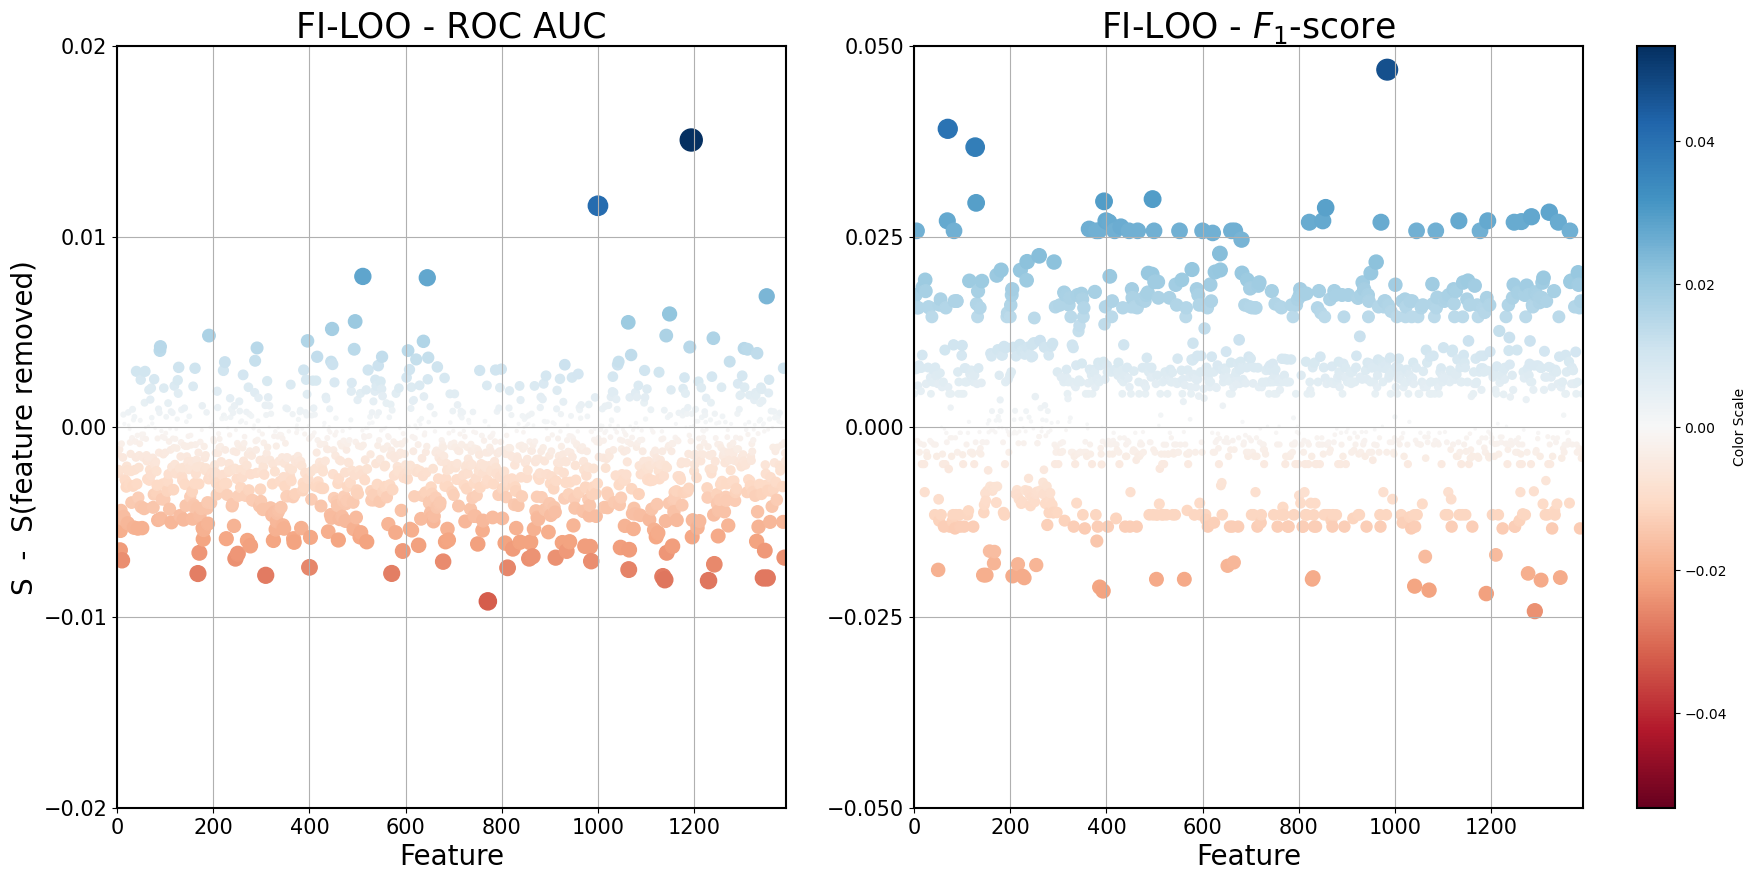

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [101]:
fs = [44,1240,1000,1031,257,637, 1063]
names = ["ROC AUC", r"$F_1$-score"]
gridspec = {'width_ratios': [1, 1]}

mpl.rcParams['axes.linewidth'] = 1.5

plt.subplots_adjust(hspace=30)
fig, ax = plt.subplots(1,2,figsize=(20,10), dpi=100, gridspec_kw=gridspec)
for ii, m in enumerate(["rocs", "f1s"]):
    red_name ="fi-loco"
    file1 = np.load(f"results/{red_name}/extranew4_{m}1.npy")
    #ile2 = np.load(f"results/{red_name}/extranew_{m}2.npy")
    full = file1#np.concatenate((file1, file2), axis=0)
    full = np.ma.masked_where(full==0,full)
    print(np.median(full))
    plt.figure(figsize=(10,6), dpi=100)
    #plt.hist(full, bins=100)
    cmap = mpl.cm.get_cmap("RdBu").copy()
    cmap.set_bad(color='black')
    size = (np.abs(full)-np.min(np.abs(full)))/(np.max(np.abs(full))-np.min(np.abs(full)))*2.5e2
    a = ax[ii].scatter(np.arange(full.shape[0]),full, c=full, norm=mpl.colors.CenteredNorm(), cmap=cmap, s=1+size, marker="o")
    #plt.scatter(fs,full[fs], c=full[fs]-np.mean(full[fs]), norm=mpl.colors.CenteredNorm(), cmap=cmap, s=1+np.abs(full[fs]-np.mean(full[fs]))*1e4, marker="o")
    ax[ii].set_xlabel("Feature", fontsize=20)
    ax[ii].set_xlim(0,full.shape[0])
    #plt.ylim(-0.1,0.1)
    ax[ii].grid()
    ax[ii].set_title(f"FI-LOO - {names[ii]}", fontsize=25)
ax[0].set_ylim(-0.02,0.02)
ax[1].set_ylim(-0.05,0.05)
ax[0].set_yticks([-0.02,-0.01,0.0,0.01,0.02])
ax[1].set_yticks([-0.05,-0.025,0.0,0.025,0.05])
ax[0].tick_params(axis='both', labelsize=15)
ax[1].tick_params(axis='both', labelsize=15)
fig.tight_layout(pad=5)
ax[0].set_ylabel(f"S  -  S(feature removed)", fontsize=20)
cbar = fig.colorbar(a, ax=ax, location='right', shrink=1, pad=0.03)
cbar.set_label("Color Scale")
fig.savefig(f"results/plots/feature_importance_both.eps", bbox_inches='tight')
fig.show()

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\lenna\AppData\Local\Temp\ipykernel_3736\947105062.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("RdBu").copy()
C:\Users\lenna\AppData\Local\Temp\ipykernel_3736\947105062.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  plt.scatter(np.arange(full.shape[0]),full, c="silver", norm=mpl.colors.CenteredNorm(), s=1+np.abs(full-np.mean(full))*1e4, marker="o")


-0.0013914656771799594


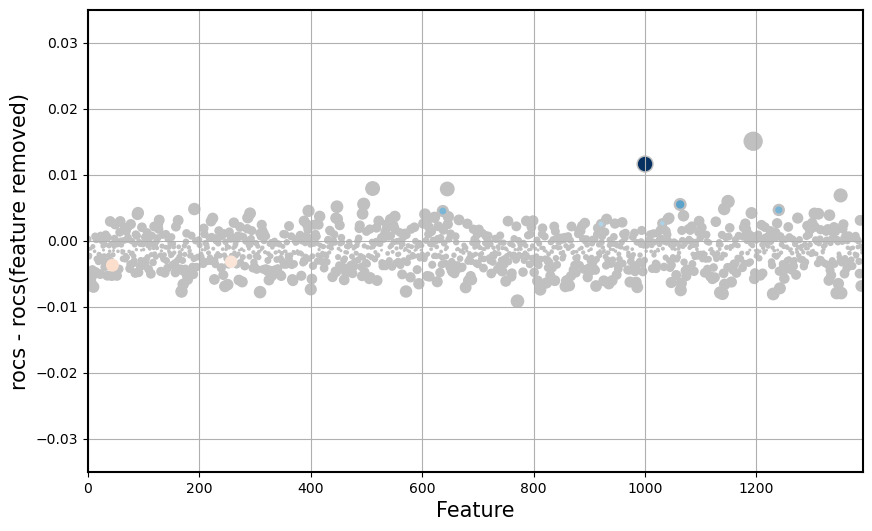

0.004354869268662354


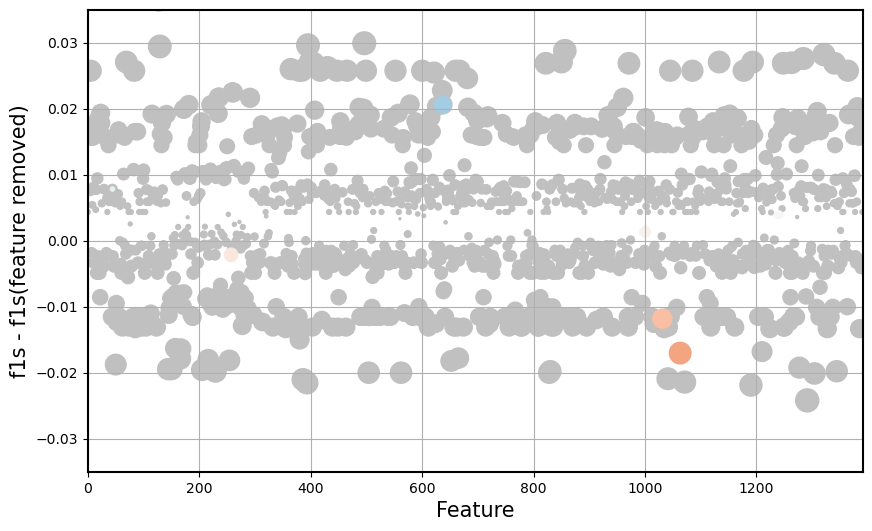

In [251]:
fs = [921,44,1240,1000,1031,257,637, 1063]
for m in ["rocs", "f1s"]:
    red_name ="fi-loco"
    file1 = np.load(f"results/{red_name}/extranew4_{m}1.npy")
    #file2 = np.load(f"results/{red_name}/extranew_{m}2.npy")
    full = file1#np.concatenate((file1, file2), axis=0)
    full = np.ma.masked_where(full==0,full)
    print(np.median(full))
    plt.figure(figsize=(10,6), dpi=100)
    #plt.hist(full, bins=100)
    cmap = mpl.cm.get_cmap("RdBu").copy()
    cmap.set_bad(color='black')
    plt.scatter(np.arange(full.shape[0]),full, c="silver", norm=mpl.colors.CenteredNorm(), s=1+np.abs(full-np.mean(full))*1e4, marker="o")
    plt.scatter(fs,full[fs], c=full[fs]-np.mean(full), norm=mpl.colors.CenteredNorm(), cmap=cmap, s=1+np.abs(full[fs]-np.mean(full[fs]))*1e4, marker="o")
    plt.xlabel("Feature", fontsize=15)
    plt.ylabel(f"{m} - {m}(feature removed)", fontsize=15)
    plt.xlim(0,full.shape[0])
    plt.ylim(-0.035,0.035)
    plt.grid()
    best = np.argsort(full)
    plt.savefig(f"results/plots/feature_importance_{m}.eps")
    plt.show()

In [ ]:
plt.hist(results[0]-np.array(rocs))
plt.show()
plt.scatter(np.arange(len(rocs)), results[0]-np.array(rocs))

From medical:

### https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2021.807648/full

s__Fusobacterium_nucleatum 637

hit

s__Enterococcus_faecalis 542

miss

s__Peptostreptococcus_anaerobius 1029

miss, but distribution look significant

s__Campylobacter_jejuni 300

hit in PFNs, not xgb

\
https://pmc.ncbi.nlm.nih.gov/articles/PMC6087872/

s__Helicobacter_pylori 685

\
https://academic.oup.com/ismej/article/6/2/320/7587697

Both more in healthy:
both miss

s__Bacteroides_vulgatus 221

s__Bacteroides_uniformis 220


\\
https://www.thieme-connect.de/products/ejournals/pdf/10.1055/s-0037-1602239.pdf

s__Peptostreptococcus_stomatis, 1031

s__Mogibacterium_diversum, 921

s__Actinomyces_odontolyticus , 44

s__Solobacterium_moorei, 1240

s__Parvimonas_micra, 1000

s__Bilophila_wadsworthia, 257


s__Prevotella_intermedia, 1063


From FI:

s__Streptococcus_parasanguinis

pfn up, medpfn down, xgb nothing, no research so far

s__Pseudopropionibacterium_propionicum
s__Pseudomonas_simiae
s__Streptococcus_sanguinis
s__Streptococcus_oralis
s__Streptococcus_milleri
s__Candida_tropicalis
s__Eubacterium_nodatum
s__Porphyromonas_asaccharolytica
s__Streptococcus_pseudopneumoniae
s__Lachnospiraceae_bacterium_oral_taxon_096
s__Streptococcus_australis
s__Oribacterium_asaccharolyticum
s__Citrobacter_braakii
s__Oribacterium_sinus
s__Selenomonas_sputigena
s__Bavariicoccus_seileri
s__Streptococcus_infantis
s__Eubacterium_infirmum
s__Parabacteroides_merdae

In [84]:

fis = np.load(f"results/fi-loco/extranew_rocs1.npy")
best = np.argsort(np.abs(fis))[::-1]
for b in best[:20]:
    print(bacteria_names[b], b)

s__Megasphaera_micronuciformis 882
s__Faecalicoccus_pleomorphus 602
s__Oribacterium_sinus 962
s__Mogibacterium_pumilum 922
s__Oribacterium_sp_oral_taxon_078 963
s__Leptotrichia_hofstadii 845
s__Streptococcus_sp_HMSC070B10 1308
s__Streptococcus_sinensis 1302
s__Gemmiger_sp_An87 652
s__Prevotella_pallens 1073
s__Treponema_denticola 1337
s__Meiothermus_silvanus 887
s__Serratia_liquefaciens 1226
s__Selenomonas_sp_FOBRC6 1218
s__Methanobrevibacter_oralis 895
s__Lelliottia_jeotgali 844
s__Selenomonas_sp_oral_taxon_138 1220
s__Streptococcus_cristatus 1277
s__Megasphaera_hexanoica 881
s__Mitsuokella_sp_oral_taxon_131 918


In [73]:
for ii, b in enumerate(bacteria_names):
    if "uniformis" in b:
        print(b, ii)

s__Bacteroides_uniformis 220
s__Megamonas_funiformis 875
s__Megamonas_funiformis_CAG_377 876


### Feature effect - Individual conditional expectation (ICE)

In [14]:
save = True
sampling = None
cv = 3
best_delete = 0
strat_split = True
max_samples = 1024
preprocess = "mix"
multi_decoder = "permutation"
N_ens = 3
seed = 42
overwrite = True
metrics = ["roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100"
run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
model = MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess)
#model = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic')
#model = TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process)

fis = np.load(f"results/fi-loco/extranew_rocs1.npy")
print(fis)
best = np.argsort(fis)[::-1]
reducer = AnovaSelect()
features = [921,44,1240,1000,1031,257,637, 1063]#+list(best[:15])
step = 0.1
num = 10
#features = [637, 1063]
#features = best[:20]
features = [257]
f = [637, 1063]
f = [1240,921]
print(f)
c1_props_list_all = []
#fvalues = np.geomspace(np.min(all_data[(all_data[:,f]>0),f])+1e-10,np.max(all_data[:,f]),num=num)
fvalues = np.geomspace(1e-10,1,num=num)
for v1 in fvalues:
    c1_props_list = []
    for v2 in fvalues:
        X_train, X_test, y_train, y_test = train_test_split(all_data, labels, train_size=1024, test_size=512, stratify=labels, random_state=42)
        
        X_test[:,f[0]] = 0
        X_test[:,f[1]] = 0
        #X_test = X_test*(1/np.sum(X_test,axis=1, keepdims=True))*(1-v1-v2)
        X_test[:,f[0]] = v1
        X_test[:,f[1]] = v2
        X_train[:,[0,f[0]]] = X_train[:,[f[0],0]]
        X_test[:,[0,f[0]]] = X_test[:,[f[0],0]]
        X_train[:,[1,f[1]]] = X_train[:,[f[1],1]]
        X_test[:,[1,f[1]]] = X_test[:,[f[1],1]]
        
        X_train, X_test = remove_same_features_traintest(X_train, X_test)
        reducer.fit(X_train, y_train)
        if (reducer.feature_indices==0).nonzero()[0]>=100:
            np.insert(reducer.feature_indices, 0, 0)
        if (reducer.feature_indices==1).nonzero()[0]>=100:
            np.insert(reducer.feature_indices, 1, 1)
        X_train, X_test = reducer.transform(X_train), reducer.transform(X_test)
        with torch.no_grad():
            model.fit(X_train, y_train)#, overwrite_warning=True)
            preds = model.predict_proba(X_test)
        c1_probs = (preds[:,1]-preds[:,0]+1)*0.5
        c1_props_list.append(c1_probs)
    c1_props_list_all.append(c1_props_list)
ice_curves = np.array(c1_props_list_all)
red_name ="ice"
directory = f"results/{red_name}"
if not os.path.exists(directory):
    os.makedirs(directory)
#np.save(f"results/ice/{model.__class__.__name__}_feature{f}.npy", ice_curves)
np.save(f"results/ice/newmod_small_f1{f[0]}_f2{f[1]}_.npy", ice_curves)
#np.save(f"results/ice/pfnfeature{f}.npy", ice_curves)

[-0.01022727 -0.01032004 -0.01032004 ... -0.0156308  -0.0156308
 -0.0156308 ]
[1240, 921]


In [86]:
save = True
sampling = None
cv = 3
best_delete = 0
strat_split = True
max_samples = 1024
preprocess = "mix"
multi_decoder = "permutation"
N_ens = 3
seed = 42
overwrite = True
metrics = ["roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100"
run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
model = MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess)
model = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic')
#model = TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode="false")

#fis = np.load(f"results/fi-loco/extranew_{m}1.npy")
#print(fis)
#best = np.argsort(np.abs(fis))[::-1]
reducer = AnovaSelect()
features = [921,44,1240,1000,1031,257,637, 1063]#+list(best[:15])
features = [96,272,115,119]
step = 0.1
num = 100
#features = [637, 1063]
#features = best[:20]
#features = [1223, 1342]
for f in features:
    print(f)
    c1_props_list = []
    fvalues = np.geomspace(np.min(all_data[(all_data[:,f]>0),f])+1e-10,np.max(all_data[:,f]),num=num)
    fvalues = np.geomspace(1e-10,1,num=num)
    for v in fvalues:
        X_train, X_test, y_train, y_test = train_test_split(all_data, labels, train_size=1024, test_size=512, stratify=labels, random_state=42)
        #X_train[:,f] = 0
        X_test[:,f] = 0
        #X_train = X_train*(1/np.sum(X_train,axis=1, keepdims=True))*(1-v)
        X_test = X_test*(1/np.sum(X_test,axis=1, keepdims=True))*(1-v)
        #X_train[:,f] = v
        X_test[:,f] = v
        #X_test += np.random.normal(0,1,size=X_test.shape)
        X_train[:,[0,f]] = X_train[:,[f,0]]
        X_test[:,[0,f]] = X_test[:,[f,0]]
        X_train, X_test = remove_same_features_traintest(X_train, X_test)
        reducer.fit(X_train, y_train)
        #X_train
        #np.insert(reducer.feature_indices, 0, 921)
        #print((reducer.feature_indices==0).nonzero())
        if (reducer.feature_indices==0).nonzero()[0]>=100:
            np.insert(reducer.feature_indices, 0, 0)
        X_train, X_test = reducer.transform(X_train), reducer.transform(X_test)
        with torch.no_grad():
            model.fit(X_train, y_train)#, overwrite_warning=True)
            preds = model.predict_proba(X_test)
        c1_probs = (preds[:,1]-preds[:,0]+1)*0.5
        c1_props_list.append(c1_probs)
    ice_curves = np.array(c1_props_list)
    red_name ="ice"
    directory = f"results/{red_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    #np.save(f"results/ice/{model.__class__.__name__}_feature{f}.npy", ice_curves)
    #np.save(f"results/ice/newmod_small_feature{f}.npy", ice_curves)
    #np.save(f"results/ice/pfnfeature{f}.npy", ice_curves)

882


In [138]:
path = "datasets/data_all.csv"
df = pd.read_csv(path)
df = df.loc[(df["disease"] == "healthy") | (df["disease"]=="CRC")]
df = df.iloc[:,2:-5]
df = df.div(df.sum(axis=1), axis=0)
df = df.loc[:, (df != 0).any(axis=0)]
bacteria_names = list(df)

In [243]:
fis = np.load(f"results/fi-loco/extranew4_rocs1.npy")
best = np.argsort(fis)
print(best[0])

771


C:\Users\lenna\AppData\Local\Temp\ipykernel_3736\4224827641.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\lenna\AppData\Local\Temp\ipykernel_3736\4224827641.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\lenna\AppData\Local\Temp\ipykernel_3736\4224827641.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\lenna\AppData\Local\Temp\ipykernel_3736\4224827641.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\lenna\AppData\Local\Temp\ipykernel_3736\4224827641.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


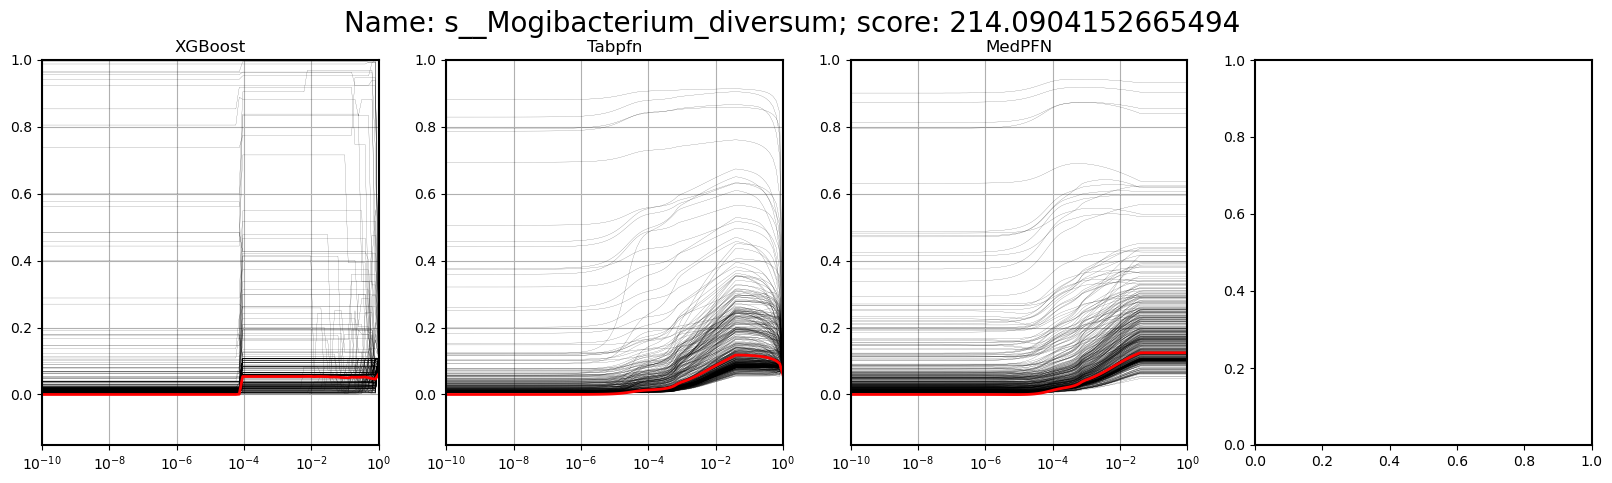

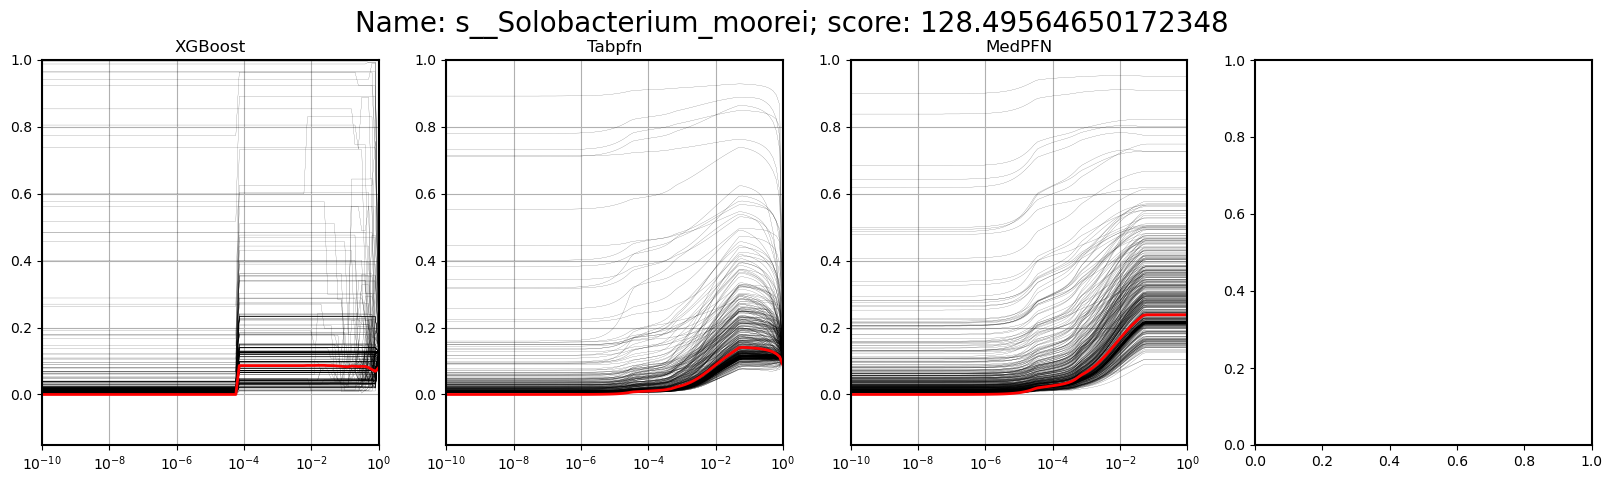

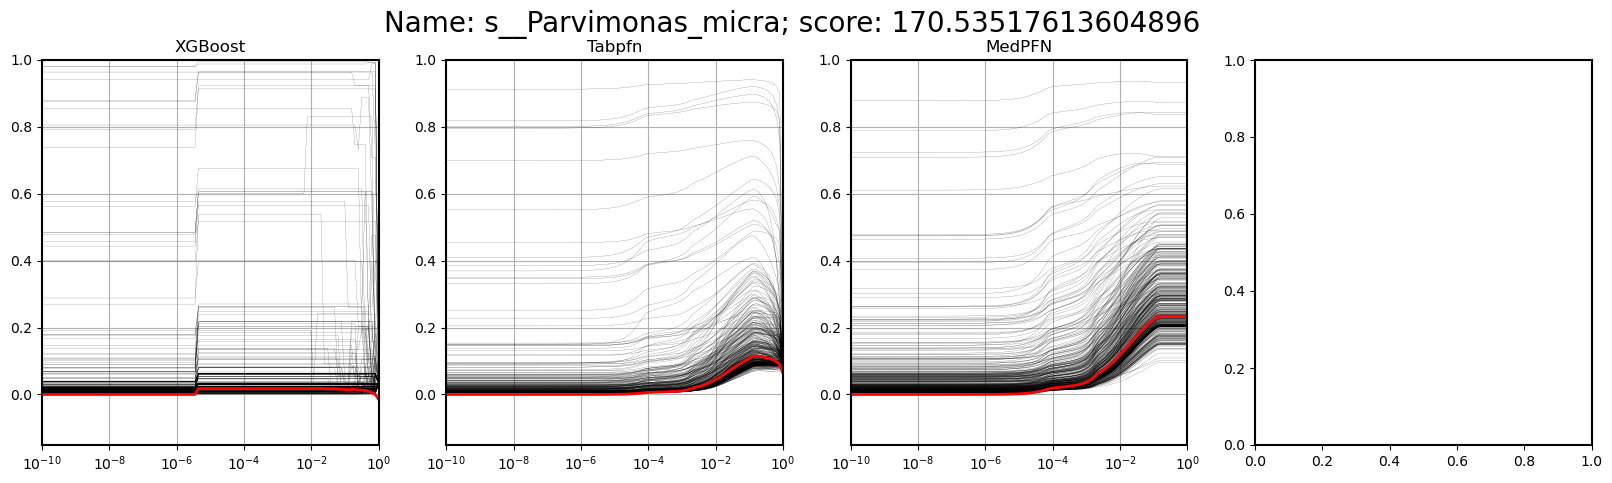

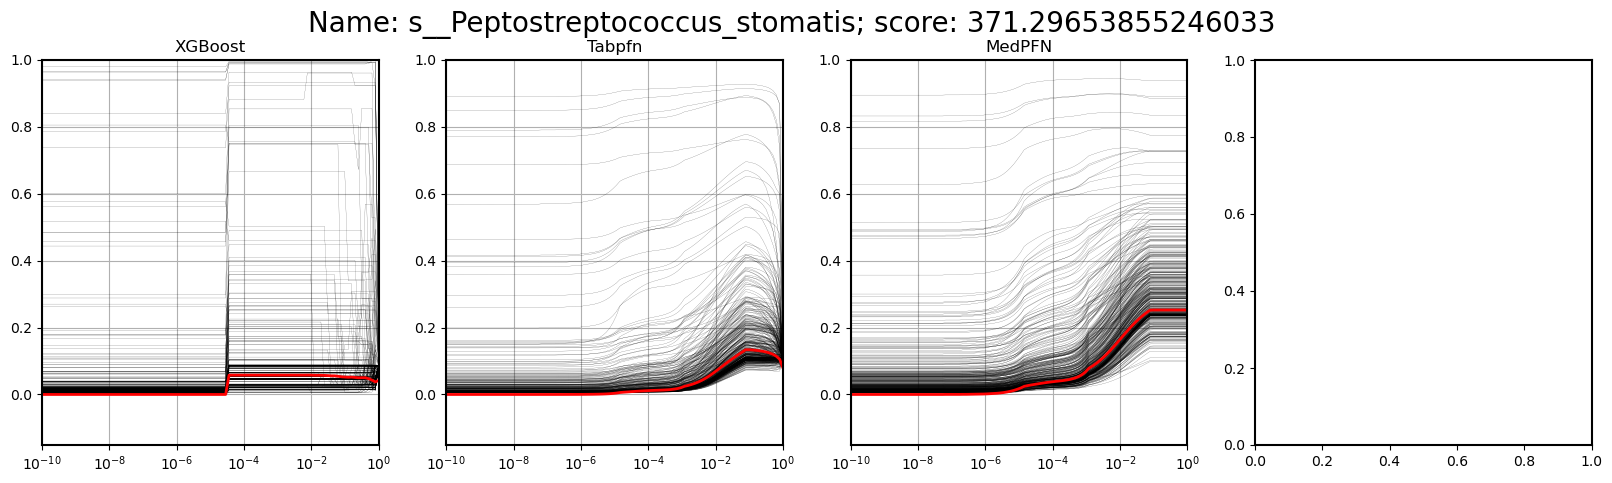

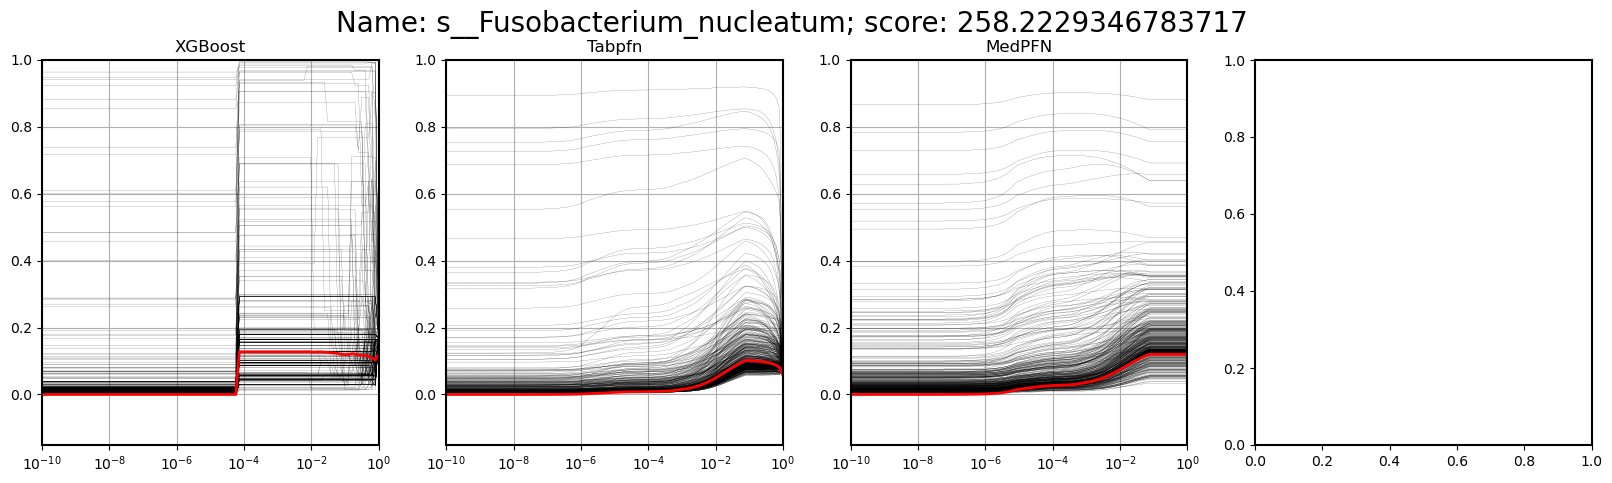

In [395]:
num = 100
features = [1223, 1342]#[637, 1063, 921]#+list(best[:50])#[637, 1063]#best[50:100]#[921]
features = [921,44,1240,1000,1031,257,637, 1063]
features = [921,1240,1000,1031,637]
#features = [921]
fis = np.load(f"results/fi-loco/extranew4_rocs1.npy")
#print(fis)
reducer = AnovaSelect()
best = np.argsort(fis)[::-1]
#features = best[:5]
names = ["XGBClassifier_", "pfn", "newmod_small_"]
titles = ["XGBoost", "Tabpfn", "MedPFN"]
for f in features:
    fig, ax = plt.subplots(1, 4, dpi=100, figsize = (20,5))
    fvalues = np.geomspace(np.min(all_data[(all_data[:,f]>0),f])+1e-10,np.max(all_data[:,f]),num=num)
    fvalues = np.geomspace(1e-10,1,num=num)
    #print(fvalues)
    #print(ice_curves.shape)
    c0_features = all_data[labels==0,f]
    #print(np.mean((c0_features!=0)*1))
    c1_features = all_data[labels==1,f]
    #print(np.mean((c1_features!=0)*1))
    for mod in range(3):
        ice_curves = np.load(f"results/ice/{names[mod]}feature{f}.npy")
        for i in range(512):
            ax[mod].plot(fvalues, ice_curves[:,i], linewidth=0.1, c="black")
            #plt.plot(fvalues, ice_curves[:,i], linewidth=0.1, c="black")
        ax[mod].plot(fvalues, np.mean(ice_curves-ice_curves[0,:], axis=1), linewidth=2.0, c="red")
        #plt.plot(fvalues, np.mean(ice_curves, axis=1), linewidth=0.5, c="red")
        ax[mod].set_ylim(-0.15,1)
        ax[mod].set_xlim(1e-10,1)
        ax[mod].set_title(titles[mod])
        ax[mod].grid()
        ax[mod].set_xscale("log")
        
    bins = np.linspace(0,0.001,20)#np.geomspace(1e-10,1e-2,num=num)
    new_data = np.concatenate((c0_features,c1_features),axis=0)
    c = np.concatenate((np.zeros(c0_features.shape[0]),np.ones(c1_features.shape[0])))
    #ax[3].scatter(np.arange(all_data.shape[0]),new_data[:], c=c)#,c=labels)
    #ax[3].set_yscale("log")
    #ax[3].set_ylim(0,0.1)
    #ax[3].hist(c0_features,bins=bins, rwidth=0.5, align="left", weights=np.ones_like(c0_features)/len(c0_features))
    #ax[3].hist(c1_features,bins=bins, rwidth=0.5, align="mid", weights=np.ones_like(c1_features)/len(c1_features))
    reducer.fit(all_data, labels)
    fig.suptitle(f"Name: {bacteria_names[f]}; score: {reducer.anova.scores_[f]}", fontsize=20)
    fig.show()

1228
s__Serratia_proteamaculans
594
s__Eubacterium_yurii
673
s__Haemophilus_sp_C1
893
s__Methanobacterium_sp_MB1
892
s__Methanobacterium_formicicum


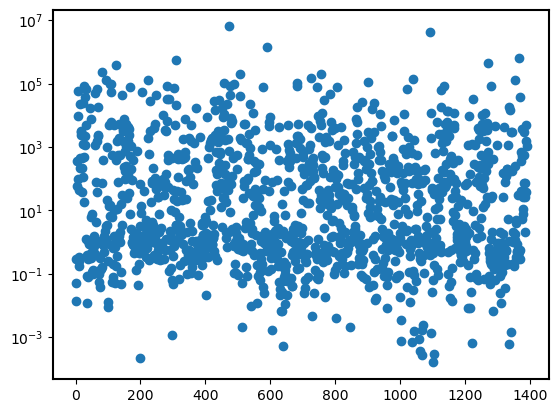

In [274]:
means_c0 = np.mean(all_data[labels==0], axis=0)
means_c1 = np.mean(all_data[labels==1], axis=0)

ratio = means_c0/(means_c1+1e-10)
plt.scatter(np.arange(all_data.shape[1]), ratio)
plt.yscale('log')
for i in range(5):
    print(np.argsort(ratio)[i])
    print(bacteria_names[np.argsort(ratio)[i]])

s__Cupriavidus_metallidurans


C:\Users\lenna\AppData\Local\Temp\ipykernel_20256\3082822403.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


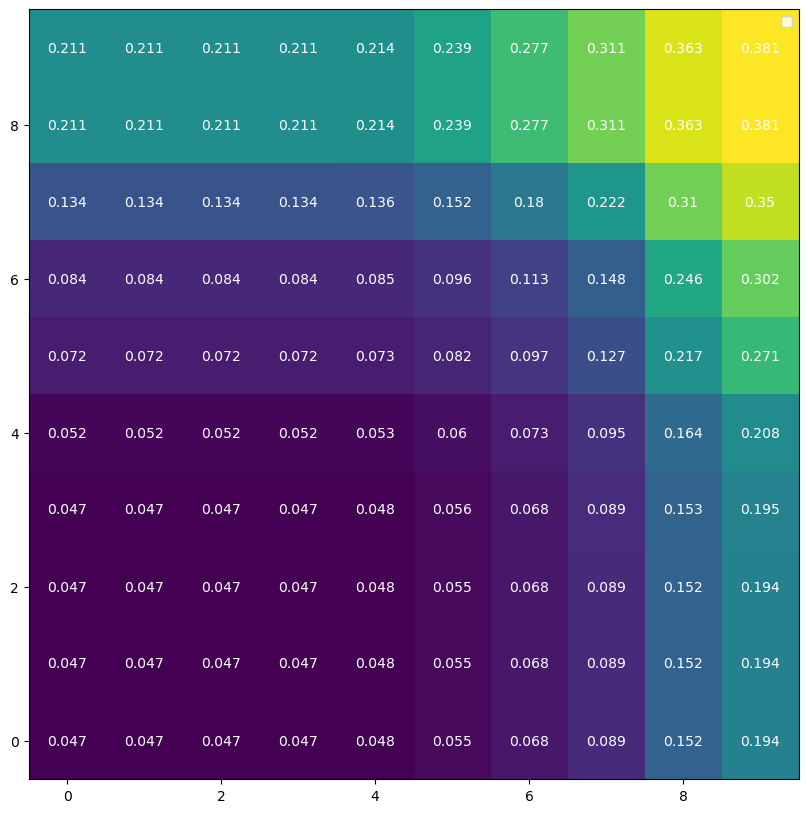

In [64]:

#print(np.where(["Prevotella_inter" in b for b in bacteria_names]))
#print(np.array(bacteria_names)[np.where(["Prevotella_inter" in b for b in bacteria_names])])

num = 10
#features = best[:20]#[637, 1063, 921]#+list(best[:50])#[637, 1063]#best[50:100]#[921]
#features = [921,44,1240,1000,1031,257,637, 1063]
#features = [1000]
#for f in features:

f = [637, 1063]
#f = [257,921]
#f = [1240,921]
fvalues = np.geomspace(1e-10,1,num=num)
#print(fvalues)
#print(ice_curves.shape)
ice_curves = np.load(f"results/ice/newmod_small_f1{f[0]}_f2{f[1]}_.npy")
means = np.mean(ice_curves, axis=-1)
fig, ax = plt.subplots(dpi=100, figsize=(10,10))
im = ax.imshow(means, origin="lower")
for i in range(num):
    for j in range(num):
        text = ax.text(j, i, np.round(means[i,j],3),
                       ha="center", va="center", color="w")
plt.legend()
plt.show()

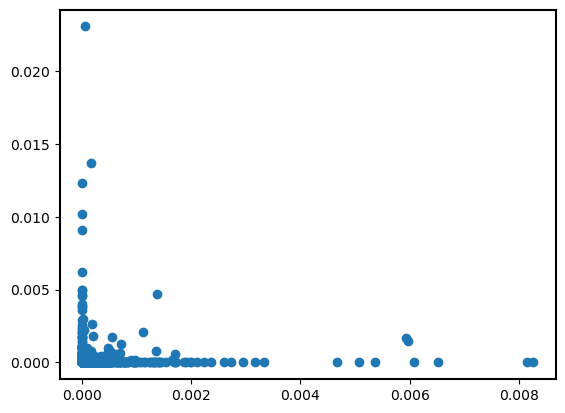

In [335]:
plt.scatter(all_data[:,921], all_data[:,637])

In [342]:
X_train, X_test, y_train, y_test = train_test_split(all_data, labels, train_size=1024, test_size=512, stratify=labels, random_state=42)
print(X_test[191,637])
print(bacteria_names[637])

0.0
s__Fusobacterium_nucleatum


C:\Users\lenna\AppData\Local\Temp\ipykernel_3736\1576727488.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\lenna\AppData\Local\Temp\ipykernel_3736\1576727488.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\lenna\AppData\Local\Temp\ipykernel_3736\1576727488.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\lenna\AppData\Local\Temp\ipykernel_3736\1576727488.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


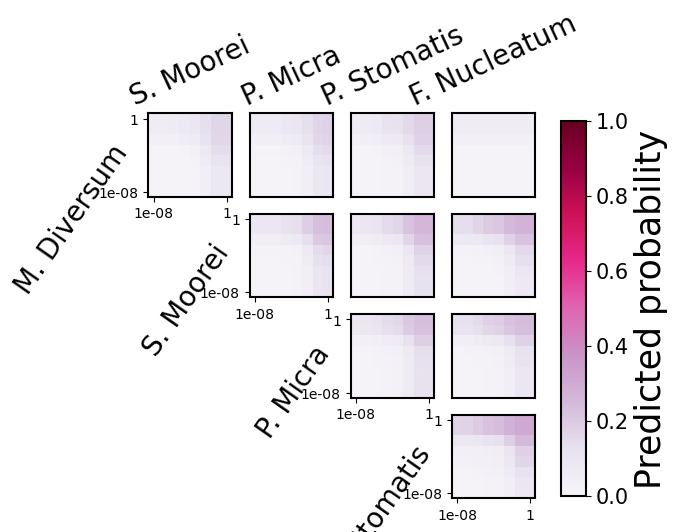

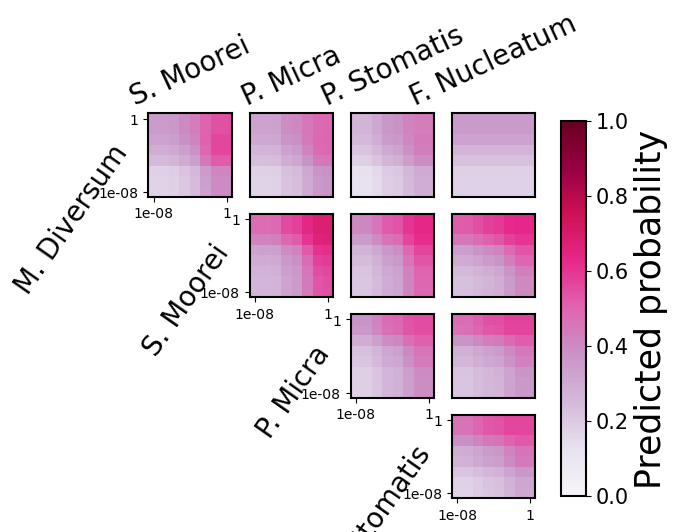

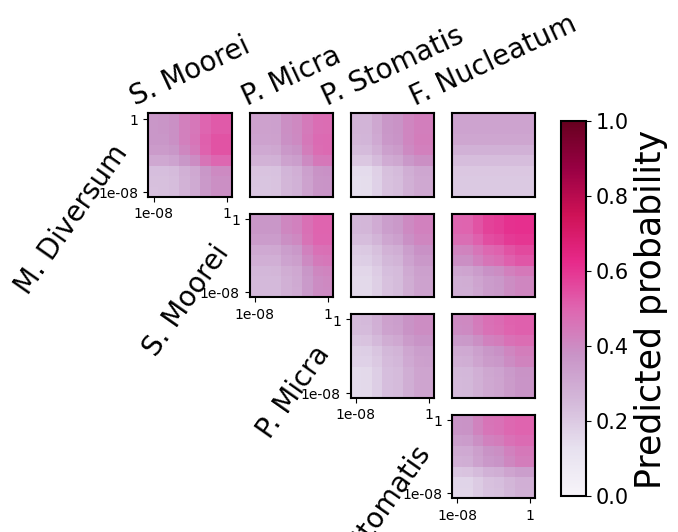

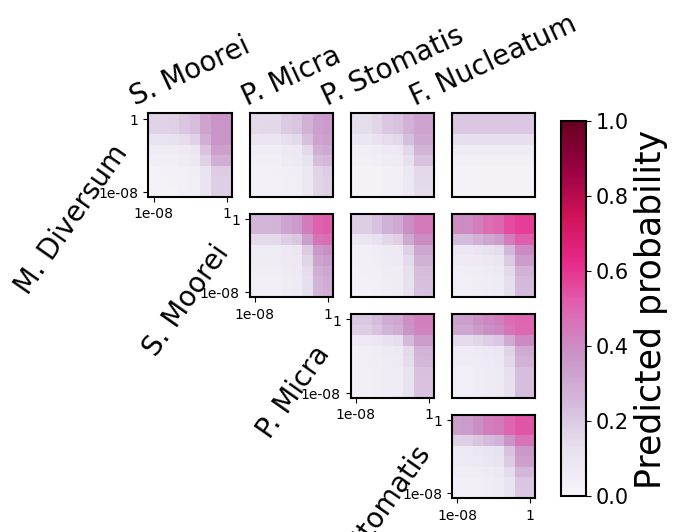

In [392]:
features = [921,44,1240,1000,1031,257,637, 1063]
features = [921,1240,1000,1031,637]

bnames = ["M. Diversum", "S. Moorei", "P. Micra", "P. Stomatis", "F. Nucleatum", "P. Intermedia"]
data = np.load(f"results/ice/newmod_small_f1_{1063}_f2_{1063}_.npy")
vmin = 0#np.min(np.mean(data[:,0:10,0:10],axis=-1))
vmax = 1#np.max(np.mean(data[:,1:10,1:10],axis=-1))
'''for i in range(8):
    for j in range(8):
        data = np.load(f"results/ice/newmod_small_f1_{features[i]}_f2_{features[j]}_.npy")
        #print(data.shape)
        data_fix = data[i*80+j*10:i*80+j*10+10]
        np.save(f"results/ice/newmod_small_f1_{features[i]}_f2_{features[j]}_fixed.npy", data_fix)'''
#x2 = remove_zero_features(x2)
#class_assigner = priors.flexible_categorical.BalancedBinarize()#MulticlassRank(hyperparameters['num_classes'], ordered_p=hyperparameters['output_multiclass_ordered_p'])
#b = class_assigner(b)
N = len(features)

data = np.load(f"results/ice/newmod_small_f1_{1031}_f2_{637}_.npy")
lowest = np.argmin(data[-2,-2,:])
strongest = np.argmax(data[-2,-2,:])
fvalues = np.geomspace(1e-10,1,num=10)
for p in [96,272,115,119]:#np.random.choice(512,10, False):
    fig = plt.figure(figsize=(5,5))
    for i in range(N-1):
        for j in range(N):
            data = np.load(f"results/ice/newmod_small_f1_{features[i]}_f2_{features[j]}_fixed.npy")
            #print(data.shape)
            #data_fix = data[i*80+j*10+1:i*80+j*10+9,1:9]
            #print(data_fix.shape)
            #print(data_fix.shape)
            if(j>i) :
                ax = plt.subplot2grid((N-1, N-1), (i,j-1))
                ax.set_xticks([])
                ax.set_yticks([])
                if j==i+1:
                    ax.set_ylabel(bnames[i], labelpad=-25, horizontalalignment="right", rotation=55, fontsize=20)
                    #ax.set_ylabel(i, labelpad=10, horizontalalignment="right", rotation="horizontal")
                    ax.set_xticks([0,7],[1e-8,1])
                    ax.set_yticks([0,7],[1e-8,1])
                if i==0:
                    ax.set_title(bnames[j],rotation=25, x=0.5,y=1, fontsize=20)
                    #ax.set_title(j,rotation=45)
                #ax.xaxis.set_ticklabels([]) 
                #ax.yaxis.set_ticklabels([])
                a = plt.imshow(data[2:10,2:10,p], origin="lower", vmin=vmin, vmax=vmax, cmap="PuRd")
                #plt.title(f"p: {p}")
                #x = np.arange(10)
                #fig2, ax2 = plt.subplots(subplot_kw={'projection': '3d'})
                #ax.plot_trisurf(x, y, z, vmin=z.min() * 2, cmap=cm.Blues)
                #ax2.plot_wireframe(x, x, np.mean(data_fix,axis=-1))
    
    cbar_ax = fig.add_axes([0.95, 0.115, 0.05, 0.75])  # [left, bottom, width, height]
    cbar = fig.colorbar(a, cax=cbar_ax, pad=1.5)
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label("Predicted probability", fontsize=25)
    fig.savefig(f"results/plots/ice_x2_p{p}.eps", bbox_inches='tight')
    fig.show()

C:\Users\lenna\AppData\Local\Temp\ipykernel_20256\3082822403.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


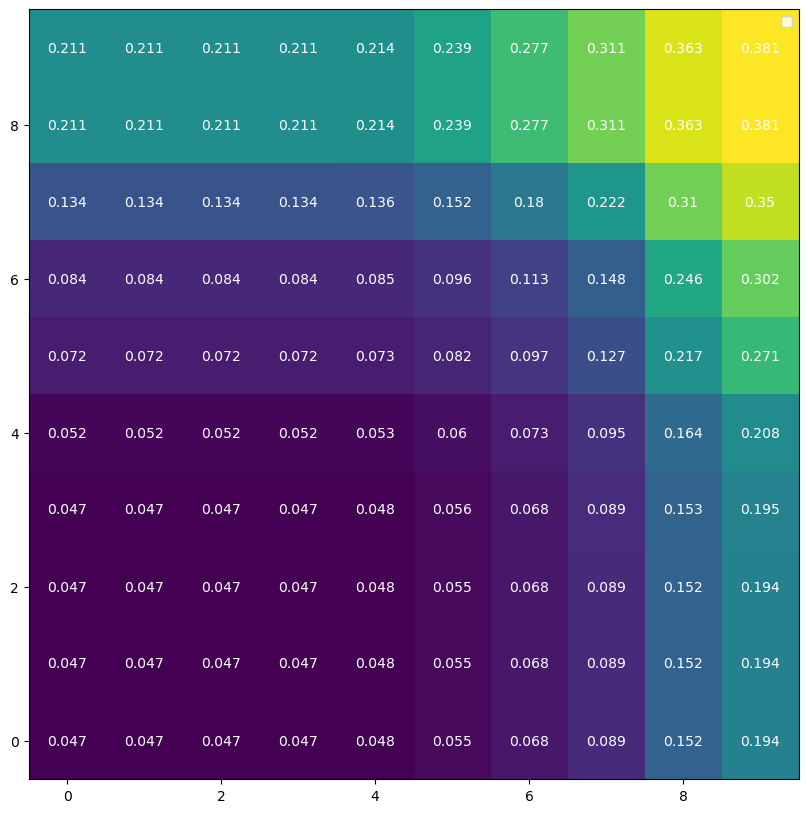

In [64]:

#print(np.where(["Prevotella_inter" in b for b in bacteria_names]))
#print(np.array(bacteria_names)[np.where(["Prevotella_inter" in b for b in bacteria_names])])

num = 10
#features = best[:20]#[637, 1063, 921]#+list(best[:50])#[637, 1063]#best[50:100]#[921]
#features = [921,44,1240,1000,1031,257,637, 1063]
#features = [1000]
#for f in features:

f = [637, 1063]
#f = [257,921]
#f = [1240,921]
fvalues = np.geomspace(1e-10,1,num=num)
#print(fvalues)
#print(ice_curves.shape)
ice_curves = np.load(f"results/ice/newmod_small_f1{f[0]}_f2{f[1]}_.npy")
means = np.mean(ice_curves, axis=-1)
fig, ax = plt.subplots(dpi=100, figsize=(10,10))
im = ax.imshow(means, origin="lower")
for i in range(num):
    for j in range(num):
        text = ax.text(j, i, np.round(means[i,j],3),
                       ha="center", va="center", color="w")
plt.legend()
plt.show()

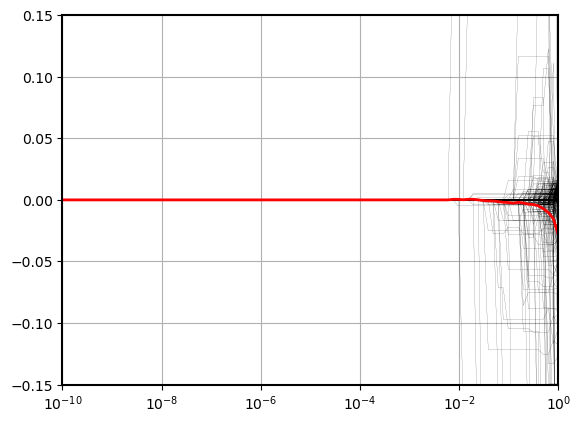

In [271]:

#print(np.where(["Prevotella_inter" in b for b in bacteria_names]))
#print(np.array(bacteria_names)[np.where(["Prevotella_inter" in b for b in bacteria_names])])

num = 100
features = best[:20]#[637, 1063, 921]#+list(best[:50])#[637, 1063]#best[50:100]#[921]
#features = [921,44,1240,1000,1031,257,637, 1063]
features = [1000]
#for f in features:
fvalues = np.geomspace(1e-10,1,num=num)
#print(fvalues)
#print(ice_curves.shape)
ice_curves = np.load(f"results/ice/xgbfeature1228.npy")
for i in range(512):
    plt.plot(fvalues, ice_curves[:,i]-ice_curves[0,i], linewidth=0.1, c="black")
    #plt.plot(fvalues, ice_curves[:,i], linewidth=0.1, c="black")
plt.plot(fvalues, np.mean(ice_curves-ice_curves[0,:], axis=1), linewidth=2, c="red")
#plt.plot(fvalues, np.mean(ice_curves, axis=1), linewidth=0.5, c="red")
plt.ylim(-0.15,0.15)
plt.xlim(1e-10,1)
plt.grid()
plt.xscale("log")
#plt.title(bacteria_names[f])
plt.show()

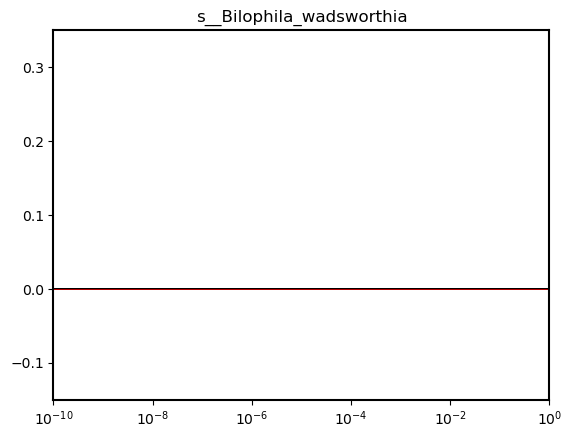

In [252]:

#print(np.where(["Prevotella_inter" in b for b in bacteria_names]))
#print(np.array(bacteria_names)[np.where(["Prevotella_inter" in b for b in bacteria_names])])

num = 100
#features = [637, 1063, 921]#+list(best[:50])#[637, 1063]#best[50:100]#[921]
#features = best[:20]
#features = [921,44,1240,1000,1031,257,637, 1063]
features = [257]
for f in features:
    fvalues = np.geomspace(np.min(all_data[(all_data[:,f]>0),f])+1e-10,np.max(all_data[:,f]),num=num)
    fvalues = np.geomspace(1e-10,1,num=num)
    #print(fvalues)
    #print(ice_curves.shape)
    ice_curves = np.load(f"results/ice/newmod_small_feature{f}.npy")
    for i in range(512):
        plt.plot(fvalues, ice_curves[:,i]-ice_curves[0,i], linewidth=0.1, c="black")
    plt.plot(fvalues, np.mean(ice_curves-ice_curves[0,:], axis=1), linewidth=0.5, c="red")
    plt.ylim(-0.15,0.35)
    plt.xlim(1e-10,1)
    plt.xscale("log")
    plt.title(bacteria_names[f])
    plt.show()

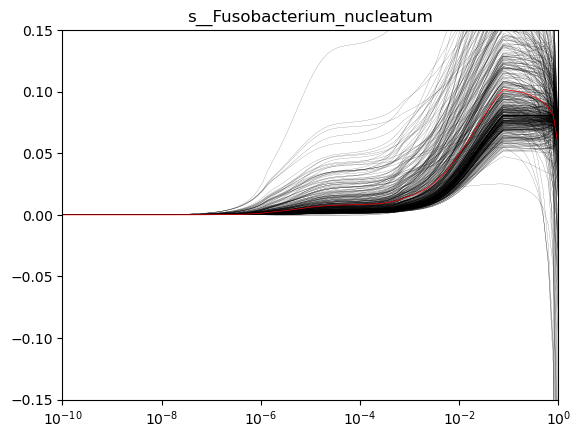

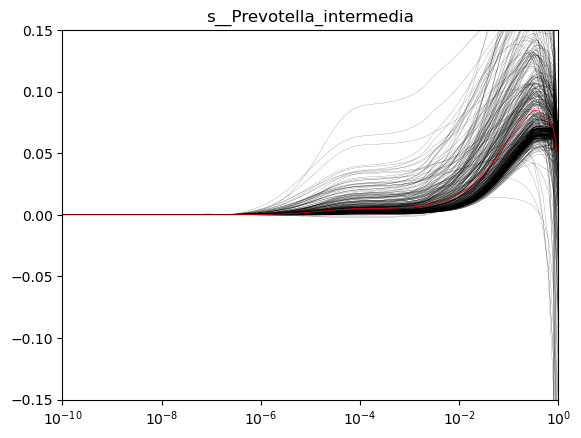

In [51]:

#print(np.where(["Prevotella_inter" in b for b in bacteria_names]))
#print(np.array(bacteria_names)[np.where(["Prevotella_inter" in b for b in bacteria_names])])

num = 100
#features = [637, 1063, 921]#+list(best[:50])#[637, 1063]#best[50:100]#[921]
for f in features:
    fvalues = np.geomspace(np.min(all_data[(all_data[:,f]>0),f])+1e-10,np.max(all_data[:,f]),num=num)
    fvalues = np.geomspace(1e-10,1,num=num)
    #print(fvalues)
    #print(ice_curves.shape)
    ice_curves = np.load(f"results/ice/pfnfeature{f}.npy")
    for i in range(512):
        plt.plot(fvalues, ice_curves[:,i]-ice_curves[0,i], linewidth=0.1, c="black")
    plt.plot(fvalues, np.mean(ice_curves-ice_curves[0,:], axis=1), linewidth=0.5, c="red")
    plt.ylim(-0.15,0.15)
    plt.xlim(1e-10,1)
    plt.xscale("log")
    plt.title(bacteria_names[f])
    plt.show()

### Data valuation - Leave-one-out (LOO)

In [ ]:
save = True
no_pre_process = False
multi_decoder = "permutation"
N_ens = 3
seed = 42
overwrite = True
metrics = ["roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_mlp_var_balance_05weight_anova"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
model = MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process)

reducer = AnovaSelect()

n_folds = 7
s = all_data.shape[0]
data_c0 = all_data[labels==0]
data_c1 = all_data[labels==1]
c0_frac = data_c0.shape[0]/all_data.shape[0]
c1_frac = 1-c0_frac#data_c1.shape[0]/all_data.shape[0]
X_folds, y_folds = [], []
fs = int(s/n_folds)
for nr in range(n_folds-1):
    fold = np.concatenate((data_c0[int(fs*c0_frac)*nr:int(fs*c0_frac)*(nr+1),:],
                          data_c1[int(fs*c1_frac)*nr:int(fs*c1_frac)*(nr+1),:]),axis=0)
    new_labels = np.concatenate((np.zeros(int(fs*c0_frac)), np.ones(int(fs*c1_frac))))
    X_folds.append(fold)
    y_folds.append(new_labels)
fold = np.concatenate((data_c0[int(fs*c0_frac)*(n_folds-1):],
                      data_c1[int(fs*c1_frac)*(n_folds-1):]),axis=0)
new_labels = np.concatenate((np.zeros(data_c0.shape[0]-int(fs*c0_frac)*(n_folds-1)), np.ones(data_c1.shape[0]-int(fs*c1_frac)*(n_folds-1))))
X_folds.append(fold)
y_folds.append(new_labels)
dvs = []
for run in range(n_folds):
    print(run)
    X_folds = X_folds[run+1:] + X_folds[:run+1]
    y_folds = y_folds[run+1:] + y_folds[:run+1]
    X_test, y_test = np.concatenate(tuple(X_folds[:-1])), np.concatenate(tuple(y_folds[:-1]))
    X_train, y_train = X_folds[-1], y_folds[-1]
    X_train, X_test = remove_same_features_traintest(X_train, X_test)
    X_train, y_train = unison_shuffled_copies(X_train, y_train)
    X_test, y_test = unison_shuffled_copies(X_test, y_test)
    reducer.fit(X_train, y_train)
    X_train = reducer.transform(X_train)
    X_test = reducer.transform(X_test)
    X_test, y_test = X_test[:512], y_test[:512]
    # with datapoint
    model.fit(X_train, y_train, overwrite_warning=True)
    probs = model.predict_proba(X_test)
    #if model_clean.__class__.__name__=="MedPFNClassifier":
    probs = (probs[:,1]-probs[:,0]+1)*0.5
    m = "roc_auc"
    result = sklearn.metrics.get_scorer(m)._score_func(y_test, probs)
    #print(result)
    for x in range(X_train.shape[0]):
        #without datapoint
        X_train_wo = np.delete(X_train, x, axis=0)
        y_train_wo = np.delete(y_train, x, axis=0)
        model.fit(X_train_wo, y_train_wo, overwrite_warning=True)
        probs = model.predict_proba(X_test)
        #if model_clean.__class__.__name__=="MedPFNClassifier":
        probs = (probs[:,1]-probs[:,0]+1)*0.5
        m = "roc_auc"
        result_wo = sklearn.metrics.get_scorer(m)._score_func(y_test, probs)
    dvs.append(result-result_wo)

0
1
2
